<a href="https://colab.research.google.com/github/gvnbleid/2020-GUM/blob/master/MGU_Projekt_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Integracja z Google Drive

In [110]:
from google.colab import drive
drive.mount('/content/gdrive')
BASE_DIR = '/content/gdrive/My Drive/DL2020/Projekt2/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Sieć konwolucyjna

## Konfiguracja wstępna

In [0]:
%matplotlib inline

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms

In [113]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cuda not available")
print(device)

cuda:0


In [0]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

## Ustawienia augmentacji danych

In [0]:
#@title Metody augmentacji { run: "auto" }
translation_checkbox = False #@param {type:"boolean"}
flip_checkbox = False #@param {type:"boolean"}
rotation_checkbox = False #@param {type:"boolean"}
noise_checkbox = False #@param {type:"boolean"}

In [0]:
transforms_array = []

if translation_checkbox:
    transforms_array.append(transforms.RandomAffine(0, (0.2, 0.2)))
if flip_checkbox:
    transforms_array.append(transforms.RandomHorizontalFlip())
if rotation_checkbox:
    transforms_array.append(transforms.RandomRotation(30))

transforms_array.append(transforms.ToTensor())
transforms_array.append(transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)))

if noise_checkbox:
    transforms_array.append(AddGaussianNoise(0., 0.2))

## Wczytanie danych

In [117]:
transform = transforms.Compose(transforms_array)

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


plane plane   dog truck


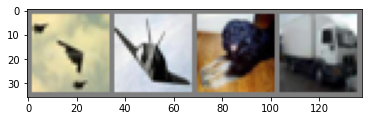

In [118]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Konfiguracja sieci

In [119]:
#@title Wybór konfiguracji { run: "auto" }

config = "PyTorch tutorial" #@param ["Adventures in Machine Learning", "PyTorch tutorial"]

last_epoch = 0
last_loss = None

class Net(nn.Module):
    if config == "PyTorch tutorial":
        def __init__(self):
            super(Net, self).__init__()
            self.conv1 = nn.Conv2d(3, 6, 5)
            self.pool = nn.MaxPool2d(2, 2)
            self.conv2 = nn.Conv2d(6, 16, 5)
            self.fc1 = nn.Linear(16 * 5 * 5, 120)
            self.fc2 = nn.Linear(120, 84)
            self.fc3 = nn.Linear(84, 10)

        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = x.view(-1, 16 * 5 * 5)
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return x

    elif config == "Adventures in Machine Learning":
        def __init__(self):
            super(Net, self).__init__()
            self.conv1 = nn.Conv2d(3, 32, 5)
            self.pool = nn.MaxPool2d(2, 2)
            self.conv2 = nn.Conv2d(32, 64, 5)
            self.fc1 = nn.Linear(64 * 5 * 5, 1000)
            self.fc2 = nn.Linear(1000, 10)

        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = x.view(-1, 64 * 5 * 5)
            x = F.relu(self.fc1(x))
            x = F.softmax(self.fc2(x), dim=0)
            return x

net = Net().to(device)
net

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Wczytanie stanu sieci (opcjonalne)

In [0]:
load_state = False #@param {type: "boolean"}
path = "" #@param {type: "string"}

if load_state:
    checkpoint = torch.load(path)
    net.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    criterion.load_state_dict(checkpoint['criterion_state_dict'])
    last_epoch = checkpoint['epoch']
    last_loss = checkpoint['loss']

    model.eval()

## Uczenie sieci

In [122]:
nb_epoch = 10 #@param {type: "integer"}
loss_array = []

for epoch in range(nb_epoch):  # loop over the dataset multiple times

    last_epoch = last_epoch + 1
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            last_loss = running_loss / 2000
            print('[%d, %5d] loss: %.3f' %
                (last_epoch, i + 1, last_loss))
            
            loss_array.append(last_loss)

            running_loss = 0.0
print('Finished Training')

[1,  2000] loss: 2.179
[1,  4000] loss: 1.882
[1,  6000] loss: 1.715
[1,  8000] loss: 1.619
[1, 10000] loss: 1.559
[1, 12000] loss: 1.511
[2,  2000] loss: 1.430
[2,  4000] loss: 1.391
[2,  6000] loss: 1.369
[2,  8000] loss: 1.333
[2, 10000] loss: 1.330
[2, 12000] loss: 1.286
[3,  2000] loss: 1.210
[3,  4000] loss: 1.200
[3,  6000] loss: 1.198
[3,  8000] loss: 1.197
[3, 10000] loss: 1.180
[3, 12000] loss: 1.156
[4,  2000] loss: 1.094
[4,  4000] loss: 1.103
[4,  6000] loss: 1.094
[4,  8000] loss: 1.111
[4, 10000] loss: 1.100
[4, 12000] loss: 1.106
[5,  2000] loss: 1.019
[5,  4000] loss: 1.039
[5,  6000] loss: 1.036
[5,  8000] loss: 1.047
[5, 10000] loss: 1.051
[5, 12000] loss: 1.042
[6,  2000] loss: 0.953
[6,  4000] loss: 0.976
[6,  6000] loss: 0.973
[6,  8000] loss: 0.989
[6, 10000] loss: 1.013
[6, 12000] loss: 0.974
[7,  2000] loss: 0.891
[7,  4000] loss: 0.919
[7,  6000] loss: 0.941
[7,  8000] loss: 0.943
[7, 10000] loss: 0.955
[7, 12000] loss: 0.962
[8,  2000] loss: 0.878
[8,  4000] 

### Zapis stanu modelu (opcjonalne)

In [0]:
from datetime import datetime

def append_timestamp(path):
    now = datetime.now()
    current_time = now.strftime("%y.%m.%d_%H:%M:%S")
    return path.replace(".", f"_{current_time}.")

In [0]:
save_state = True #@param {type: "boolean"}
path = "pytorch_tutorial.pt" #@param {type: "string"}
use_timestamp = True #@param {type: "boolean"}

if save_state:
    if use_timestamp:
        path = append_timestamp(path)
    torch.save({
                'epoch': last_epoch,
                'model_state_dict': net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'criterion_state_dict': criterion.state_dict(),
                'loss': last_loss
                }, BASE_DIR + path)

## Wyniki

In [125]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * accuracy))

Accuracy of the network on the 10000 test images: 61 %


In [126]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

accuracy_per_class = []

for i in range(10):
    accuracy_per_class.append({
                               'class': classes[i], 
                               'accuracy': class_correct[i] / class_total[i]
                               })
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 66 %
Accuracy of   car : 83 %
Accuracy of  bird : 49 %
Accuracy of   cat : 55 %
Accuracy of  deer : 61 %
Accuracy of   dog : 33 %
Accuracy of  frog : 65 %
Accuracy of horse : 68 %
Accuracy of  ship : 69 %
Accuracy of truck : 65 %


### Zapis wyników (opcjonalne)

In [0]:
save_results_state = True #@param {type: "boolean"}
use_timestamp = True #@param {type: "boolean"}
path = "pytorch_tutorial.json" #@param {type: "string"}

from datetime import datetime
import json
import codecs

if save_results_state:
    if use_timestamp:
        path = append_timestamp(path)

    json.dump(dict(accuracy=accuracy, accuracy_per_class=accuracy_per_class),
              codecs.open(BASE_DIR + path, 'w', encoding='utf-8'))

## Wykresy

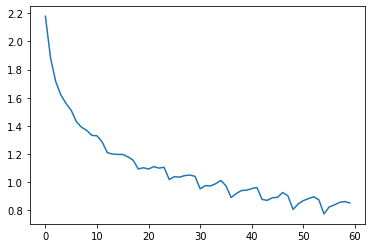

In [128]:
import matplotlib.pyplot as plt

plt.plot(loss_array)